In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
import umap

In [2]:
titanic = pd.read_csv('data/titanic.csv')

In [3]:
titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Missing data
## missForest
Step by step missForest on a generated example

In [4]:
titanic_uncleaned = titanic.copy()

In [5]:
titanic_uncleaned['Sex'].isnull().sum(), titanic_uncleaned['Fare'].isnull().sum()

(0, 0)

In [6]:
titanic_uncleaned['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
titanic_uncleaned['Fare'].mean()

32.204207968574636

In [8]:
titanic_uncleaned.loc[titanic_uncleaned.sample(6).index,'Sex'] = None
titanic_uncleaned.loc[titanic_uncleaned.sample(6).index,'Fare'] = None

In [9]:
titanic_uncleaned[titanic_uncleaned['Sex'].isnull() | titanic_uncleaned['Fare'].isnull() | titanic_uncleaned.index.isin([1, 2,30, 42])][['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked']]

,Survived,Pclass,Sex,Fare,Embarked
1,1,1,female,71.2833,C
2,1,3,female,7.9250,S
30,0,1,male,27.7208,C
42,0,3,male,7.8958,C
150,0,2,None,12.5250,S
233,1,3,None,31.3875,S
261,1,3,male,NaN,S
327,1,2,None,13.0000,S
396,0,3,female,NaN,S
416,1,2,female,NaN,S


In [10]:
sex_null = titanic_uncleaned['Sex'].isnull()
fare_null = titanic_uncleaned['Fare'].isnull()

In [11]:
titanic_uncleaned['Sex'] = titanic_uncleaned['Sex'].fillna('male')
titanic_uncleaned['Fare']= titanic_uncleaned['Fare'].fillna(titanic_uncleaned['Fare'].mean())

In [12]:
model = RandomForestRegressor()
model.fit(pd.get_dummies(titanic_uncleaned[~fare_null][['Pclass', 'Sex']], 'Sex'), titanic_uncleaned[~fare_null]['Fare'])

RandomForestRegressor()

In [13]:
y_pred = model.predict(pd.get_dummies(titanic_uncleaned[fare_null][['Pclass', 'Sex']], 'Sex'))

In [14]:
y_pred

array([ 12.60427982,  16.24581179,  21.76838782, 106.47318352,
        12.60427982, 106.47318352])

In [15]:
titanic[fare_null]['Fare']

261    31.3875
396     7.8542
416    32.5000
765    77.9583
833     7.8542
842    31.0000
Name: Fare, dtype: float64

In [16]:
titanic_uncleaned[fare_null]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,32.209486,NaN,S
396,397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,32.209486,NaN,S
416,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.209486,NaN,S
765,766,1,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,32.209486,D11,S
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,32.209486,NaN,S
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,32.209486,NaN,C


In [17]:
model = RandomForestClassifier()
model.fit(titanic_uncleaned[~sex_null][['Pclass', 'Fare']], titanic_uncleaned[~sex_null]['Sex'])
model.predict(titanic_uncleaned[sex_null][['Pclass', 'Fare']])

array(['female', 'male', 'male', 'female', 'male', 'male'], dtype=object)

# Messed-up data

## Text cleaning

In [60]:
uncleaned_name = 'uncleaned'

In [61]:
titanic[uncleaned_name] = titanic['Sex']

In [62]:
messing_up_dict = {
    'female': ['kobieta', 'mujer', 'kobiet', 'dziewczyna', 'femme', 'femalle'],
    'male': ['facet',  'Mr.', 'monsieur', 'm ale', 'mle', 'man'],
}

In [63]:
for k, v in messing_up_dict.items():
    sampled_indexes = titanic[titanic['Sex']==k].sample(frac=0.2).index
    for i in sampled_indexes:
        titanic.loc[i, uncleaned_name] = np.random.choice(v)

In [64]:
titanic[uncleaned_name].value_counts()

male          462
female        251
facet          24
man            21
mle            19
Mr.            18
m ale          18
femalle        16
femme          15
monsieur       15
mujer          12
kobieta         9
dziewczyna      7
kobiet          4
Name: uncleaned, dtype: int64

In [65]:
uncleaned = titanic.groupby(uncleaned_name).agg({'PassengerId': 'count'}).reset_index()

In [66]:
# introduce mess in the data
sex = uncleaned[uncleaned_name]

In [67]:
# pretrained model for multi language problems
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased')
sentence_embeddings = sbert_model.encode(sex)

In [68]:
# business knowledge about number of instances in a group
reducer = umap.UMAP(n_components=1)
umap_comp = reducer.fit_transform(pd.DataFrame(sentence_embeddings))

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\umap\umap_.py:1678: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [69]:
# business knowledge about number of instances in a group
pca = PCA(n_components=1)
pca_comp = pca.fit_transform(pd.DataFrame(sentence_embeddings))

In [70]:
# mapping to new vectors
titanic_ext = titanic.merge(pd.DataFrame({
    uncleaned_name: sex, 
    'pca': [el[0] for el in pca_comp], 
    'umap': [el[0] for el in umap_comp]
}))

In [71]:
# sanity check
titanic_ext.groupby('Sex').agg({'pca': 'mean'})

,pca
Sex,
female,0.363260
male,-0.256373


In [72]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [73]:
rf = RandomForestClassifier(random_state=30)

In [74]:
y = titanic_ext['Survived']

In [75]:
#titanic_ext[['Sex', 'clusters']].groupby('Sex').agg(['min', 'mean', 'max'])

In [76]:
full_sentence_embeddings = sbert_model.encode(titanic_ext['uncleaned'])

In [77]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(full_sentence_embeddings))

In [78]:
titanic_ext['clusters'] = kmeans.labels_

In [79]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(titanic_ext[['umap']])
titanic_ext['clusters_umap'] = kmeans.labels_

In [80]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(titanic_ext[['pca']])
titanic_ext['clusters_pca'] = kmeans.labels_

In [81]:
pd.crosstab(titanic_ext['Sex'], titanic_ext['clusters'])

clusters,0,1
Sex,,
female,314,0
male,0,577


In [82]:
#titanic_ext[ (titanic_ext['pca']>0) & (titanic_ext['Sex']=='female')]

In [83]:
X_dummy = pd.get_dummies(titanic_ext[['Sex']], drop_first=True)
rf.fit(X_dummy, y)
y_pred_dummy = rf.predict(X_dummy)
cross_val_score(rf, X_dummy, y, cv=cv).mean()

0.786761659657272

In [84]:
X_pca = titanic_ext[['pca']]
rf.fit(X_pca, y)
y_pred_pca = rf.predict(X_pca)
cross_val_score(rf, X_pca, y, cv=cv).mean()

0.784514468646036

In [85]:
X_clusters = titanic_ext[['clusters']]
rf.fit(X_clusters, y)
y_pred_clusters = rf.predict(X_clusters)
cross_val_score(rf, X_clusters, y, cv=cv).mean()

0.786761659657272

In [86]:
X_umap = titanic_ext[['umap']]
rf.fit(X_umap, y)
y_pred_umap = rf.predict(X_umap)
cross_val_score(rf, X_umap, y, cv=cv).mean()

0.786761659657272

In [87]:
results = titanic_ext.copy()
results['pred_dummy'] = y_pred_dummy
results['pred_pca'] = y_pred_pca
results[y_pred_dummy!=y_pred_pca]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,uncleaned,pca,umap,clusters,clusters_umap,clusters_pca,pred_dummy,pred_pca


<AxesSubplot:ylabel='Density'>

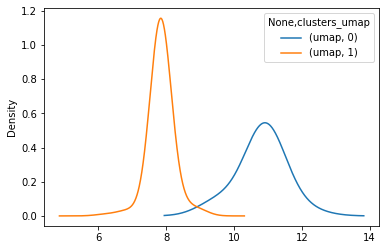

In [88]:
results[['umap', 'clusters_umap']].pivot(columns='clusters_umap').plot.kde(bw_method=1)

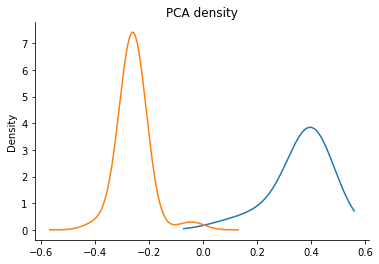

In [89]:
#ax = results['pca'].plot.density(title='PCA density')
ax = results[['pca', 'clusters_pca']].pivot(columns='clusters_pca').plot.kde(bw_method=1, title='PCA density')
#results['pca'][results['clusters']==0].plot.density(ax=ax)
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('density_pca.png')

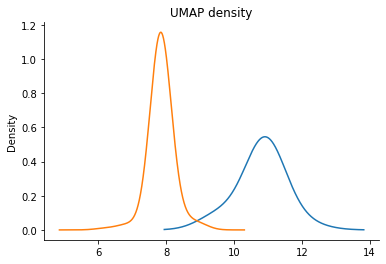

In [90]:
#ax = results['pca'].plot.density(title='PCA density')
ax = results[['umap', 'clusters_umap']].pivot(columns='clusters_umap').plot.kde(bw_method=1, title='UMAP density')
#results['pca'][results['clusters']==0].plot.density(ax=ax)
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('density_umap.png')

In [91]:
results = pd.DataFrame({
    'original': cross_val_score(rf, X_dummy, y, cv=cv),
    'pca': cross_val_score(rf, X_pca, y, cv=cv),
    'umap': cross_val_score(rf, X_umap, y, cv=cv),
    'clustering': cross_val_score(rf, X_clusters, y, cv=cv),
    'folds': range(1, 6)
})

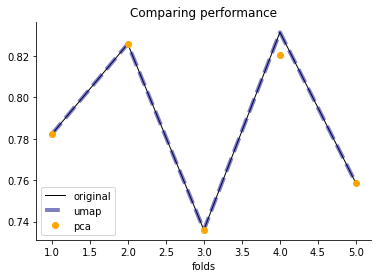

In [92]:
ax = results.plot(x='folds', y='original', c='black', lw=1, title='Comparing performance')
results.plot(x='folds', y='umap', lw=4, style="k--", ax=ax, c='darkblue', alpha=0.5)
results.plot(x='folds', y='pca', lw=2, ax=ax, style="o", c='orange')
#ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('results_umap.png')

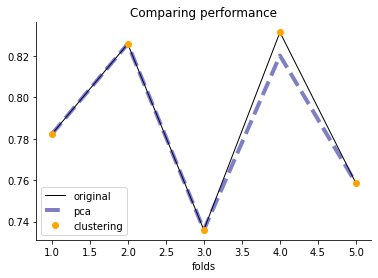

In [93]:
ax = results.plot(x='folds', y='original', c='black', lw=1, title='Comparing performance')
results.plot(x='folds', y='pca', lw=4, style="k--", ax=ax, c='darkblue', alpha=0.5)
results.plot(x='folds', y='clustering', lw=2, ax=ax, style="o", c='orange')
#ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('results.png')

## Categories cleaning

In [94]:
cat_dict = {
    'house': ['bungalow', 'semi-detached house', 'sem-detached house', 'log-house', 'cottage', 'bus', 'short-sleeved'],
    'vehicle': ['motorcoach', 'motorcycle', 'car', 'truck', 'lorry', 'lory', 'caravan', 'minivan', 'two-storey hous', 'calf-length'],
}

In [95]:
data = pd.DataFrame({
    'category': ['vehicle']*200 + ['house']*200,
    'subcategory': np.concatenate([np.random.choice(np.array(cat_dict['vehicle']), size=200), np.random.choice(np.array(cat_dict['house']), size=200)], axis=0),
    'count': 1,
})

In [96]:
data.groupby(['category', 'subcategory']).count()

count
category subcategory               
house    bungalow                28
         bus                     30
         cottage                 20
         log-house               23
         sem-detached house      32
         semi-detached house     28
         short-sleeved           39
vehicle  calf-length             18
         car                     21
         caravan                 19
         lorry                   21
         lory                    21
         minivan                 21
         motorcoach              25
         motorcycle              14
         truck                   14
         two-storey hous         26

In [97]:
category_encoded = sbert_model.encode(data['category'])
subcategory_encoded = sbert_model.encode(data['subcategory'])

In [98]:
data['similarities'] = [cosine_similarity([category_encoded[i]], [subcategory_encoded[i]])[0][0] for i in range(data.shape[0])]

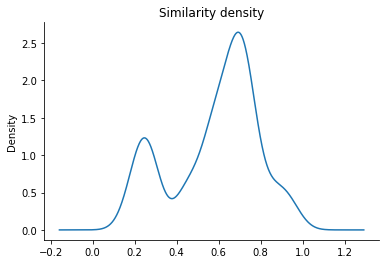

In [99]:
ax = data['similarities'].plot.kde(bw_method=0.3, title='Similarity density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
fig.savefig('similarity_density.png')

In [100]:
data.groupby(['category', 'subcategory']).agg({'similarities': 'mean', 'count': 'sum'}).reset_index().to_csv('similarities.csv')

In [101]:
data.groupby(['category', 'subcategory']).agg({'similarities': 'mean', 'count': 'sum'}).reset_index().sort_values('similarities')

,category,subcategory,similarities,count
16,vehicle,two-storey hous,0.204250,26
6,house,short-sleeved,0.260327,39
7,vehicle,calf-length,0.264653,18
1,house,bus,0.450055,30
9,vehicle,caravan,0.553825,19
0,house,bungalow,0.562262,28
5,house,semi-detached house,0.611057,28
14,vehicle,motorcycle,0.626619,14
13,vehicle,motorcoach,0.658846,25
11,vehicle,lory,0.695402,21
